# Exploring Sentiment Analysis with ML

In this notebook, we show how we have built our Sentiment classifier.

In [57]:
%matplotlib inline
from __future__ import unicode_literals
import re
import nltk
from Politweet import get_tweets, get_transcript
import ratings
from sentiment import plus_df, minus_df
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from nltk import sent_tokenize, word_tokenize, FreqDist, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sentiment import plus_regex, minus_regex, plus_regex, minus_regex
from sklearn.feature_extraction.text import TfidfTransformer
pd.set_option('display.max_colwidth', 1200)

# Get the tweets
tweets = get_tweets("./datasets/tweets.tsv")

## Choosing data for training

For train and test, we only use the tweets that have been marked with the same rating by Amazon Mechanical Turks.

In [58]:
def prepare_sentiment_data(tweets):
    neg = [(t, 'neg')
        for i,t in ratings.all(tweets, ratings.NEGATIVE).iterrows()]

    pos = [(t, 'pos')
        for i,t in ratings.all(tweets, ratings.POSITIVE).iterrows()]

    other = [(t, 'other')
        for i,t in ratings.all(tweets, ratings.OTHER).iterrows()]

    train, test = train_test_split(
        pos + neg + other, 
        test_size = .2, 
        random_state = 20)
    return train, test

#### Make sure data is tokenized

We make sure that we use our pre-processed tokenization for each tweet

In [59]:
def featurize(tweet):
    tokens = [token['lemma'] for token in tweet['clean'] if token['lemma'] != '']
    return tokens

#### Running a pipeline
The strategy is to use the pipeline design pattern.
We input data to the pipeline and this will run the pipeline, hence vectorize our input and pass it to the classifier.

In [60]:
from sklearn.metrics import classification_report

def run_pipeline(train, test, clsfr):
    # fit the classifier with training data
    train_x, train_y = zip(*train)
    test_x, test_y = zip(*test)
    clsfr.fit(train_x, train_y)
    # get accuracy on the test
    scr = classification_report(clsfr.predict(test_x), test_y)
    return scr

## TF-IDF + Polarity rules classifier (pipeline)

#### Rule Based features
This matches +1, -1.. in tweets and adds a new entry polarity(+) or polarity(-) if encountred. Engineering this feature is going to help us to get 100% accuracy on twits that have this pattern.

In [61]:
class RuleBasedSent(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self
    
    def featurize(self, document):
        features = {}
        # Positive/Negative polarity if contains a +/-
        features['polarity(+)'] = not not plus_regex.match(document["content"])
        features['polarity(-)'] = not not minus_regex.match(document["content"])
        return features

    def transform(self, docs):
        return [self.featurize(d) for d in docs]

In [62]:
pipeline_tfidf = Pipeline([
    ('features', FeatureUnion([
        ('ngram_tf_idf', Pipeline([
            ('counts', CountVectorizer(tokenizer = featurize, lowercase=False)),
            ('tf_idf', TfidfTransformer())
        ])),
        ('rule_based_system', Pipeline([
                ('match', RuleBasedSent()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
    ])),
    ('classifier', LinearSVC())
])

## TF-IDF + (learned) MechTurks 

Since we already have the scores from AMT, we decided to learn on their labels and use as training set where they all agree

In [63]:
class MechTurks(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self
    
    def rating_to_score(self, rating):
        if (rating == ratings.POSITIVE):
            return 1
        elif (rating == ratings.NEGATIVE):
            return -1
        else:
            return 0
    
    def featurize(self, document):
        features = {}
        features['rating(1)'] = self.rating_to_score(document["rating.1"])
        features['rating(2)'] = self.rating_to_score(document["rating.2"])
        features['rating(3)'] = self.rating_to_score(document["rating.2"])
        features['rating(4)'] = self.rating_to_score(document["rating.2"])
        return features

    def transform(self, docs):
        return [self.featurize(d) for d in docs]

Hence, our pipeline will combine two feature vectors. The first is the TFIDF score of each word in a tweet; the second one will run our rule based system, and give a binary vector of matched candidates.

In [64]:
pipeline_amazon = Pipeline([
    ('features', FeatureUnion([
        ('ngram_tf_idf', Pipeline([
            ('counts', CountVectorizer(tokenizer = featurize, lowercase=False)),
            ('tf_idf', TfidfTransformer())
        ])),
        ('mechturks_pipe', Pipeline([
                ('mecturks', MechTurks()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
        ('rule_based_system', Pipeline([
                ('match', RuleBasedSent()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ]))
    ])),
    ('classifier', LinearSVC())
])

## Results

In order to evaluate our system, we report precision, recall, f1-score and support for all classes and their average. In addition, we show a confusion matrix that highlights false positive and negatives.

#### TFIDF

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

train, test = prepare_sentiment_data(tweets)
run_pipeline(train, test, pipeline_tfidf)
test_x, test_y = zip(*test)

In [46]:
print classification_report(pipeline_tfidf.predict(test_x), test_y)

             precision    recall  f1-score   support

        neg       0.90      0.84      0.87       136
      other       0.48      0.70      0.57        20
        pos       0.80      0.81      0.80        58

avg / total       0.84      0.82      0.82       214



[[114  12  10]
 [  4  14   2]
 [  8   3  47]]


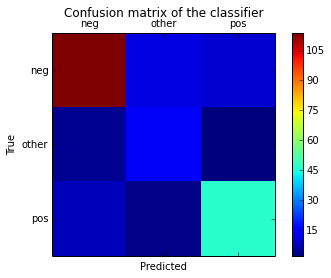

In [53]:
import pylab as plt
labels = ['neg', 'other', 'pos']
cm = confusion_matrix(pipeline_tfidf.predict(test_x), test_y)

print cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Amazon weighting

In [52]:
train, test = prepare_sentiment_data(tweets)
run_pipeline(train, test, pipeline_amazon)
test_x, test_y = zip(*test)

print classification_report(pipeline_amazon.predict(test_x), test_y)

             precision    recall  f1-score   support

        neg       1.00      0.99      1.00       127
      other       0.93      1.00      0.96        27
        pos       1.00      0.98      0.99        60

avg / total       0.99      0.99      0.99       214



[[126   1   0]
 [  0  27   0]
 [  0   1  59]]


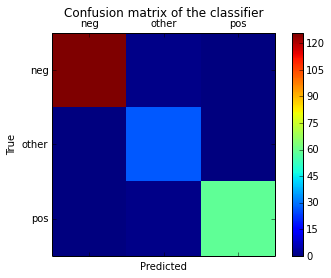

In [54]:
import pylab as plt
labels = ['neg', 'other', 'pos']
cm = confusion_matrix(pipeline_amazon.predict(test_x), test_y)

print cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Predicting and annotating tweets

Finally, for the purpose of the visualization, we predict and annotate all the tweets

In [55]:
def df_sentiment(tweets):
    tweets["sent_amazon"] = pd.Series(pipeline_amazon.predict([t for i,t in tweets.iterrows()]), index=tweets.index)
    tweets["sent_tfidf"] = pd.Series(pipeline_tfidf.predict([t for i,t in tweets.iterrows()]), index=tweets.index)
    return tweets

df_sentiment(tweets)[["content", "sent_amazon", "sent_tfidf", "rating.1"]][:3]

,content,sent_amazon,sent_tfidf,rating.1
tweet.id,,,,
936469851,Watching by myself #tweetdebate Not drinking :( waiting to start cringing at McCain blunders,neg,neg,1
936470432,"@ahg3 @MichDot Yeah, slime was actually my second choice, can't say what the first one was. Okay, we're rolling...",neg,neg,1
936472030,Preparing to have a heart attack #tweetdebate,neg,neg,1
